In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import xarray as xr

In [ ]:
path = r"Your/Path/Here/"
collocated_data = xr.open_dataset(path+"collocated.nc")

In [ ]:
# Slice the file as you wish
mask = (
    (collocated_data["sat_swh"] <= 7.5) &
    (collocated_data["model_swh_weighted"] <= 7.5) &
    (collocated_data["dist_coast"] >= 100) &
    (collocated_data["dist_coast"] >= 100) &
    (collocated_data["model_dpt"] <=-100).all(dim="nearest_nodes") &
    # (abs(ds["time_deltas"]) <= 1800) &
    (collocated_data["dist_deltas"] <= 0.05).all(dim="nearest_nodes") 
)
collocated_data = collocated_data.where(mask, drop=True)

In [ ]:
# Extract the model and the satellite data
x = collocated_data.sat_swh.values
y = collocated_data.model_swh_weighted.values #.model_swh.values.mean(axis=1)
xy_max = y.max()

In [46]:
plot_params = [
    {
        "z": abs(collocated_data.time_deltas.values),
        "label": "time delta (s)",
        "vmin": 0, "vmax": 1800,
        "cmap": "jet"
    },
    {
        "z": collocated_data.dist_deltas.values.mean(axis=1),
        "label": "dist delta (deg)",
        "vmin": 0, "vmax": 0.05,
        "cmap": "jet"
    },
    {
        "z": collocated_data.model_dpt.values.mean(axis=1),
        "label": "depths (m)",
        "vmin": -5000, "vmax": 0,
        "cmap": "jet"
    },
    {
        "z": collocated_data.dist_coast.values,
        "label": "Distance from the Coast (km)",
        "vmin": 0, "vmax": 500,
        "cmap": "jet_r"
    } 
]

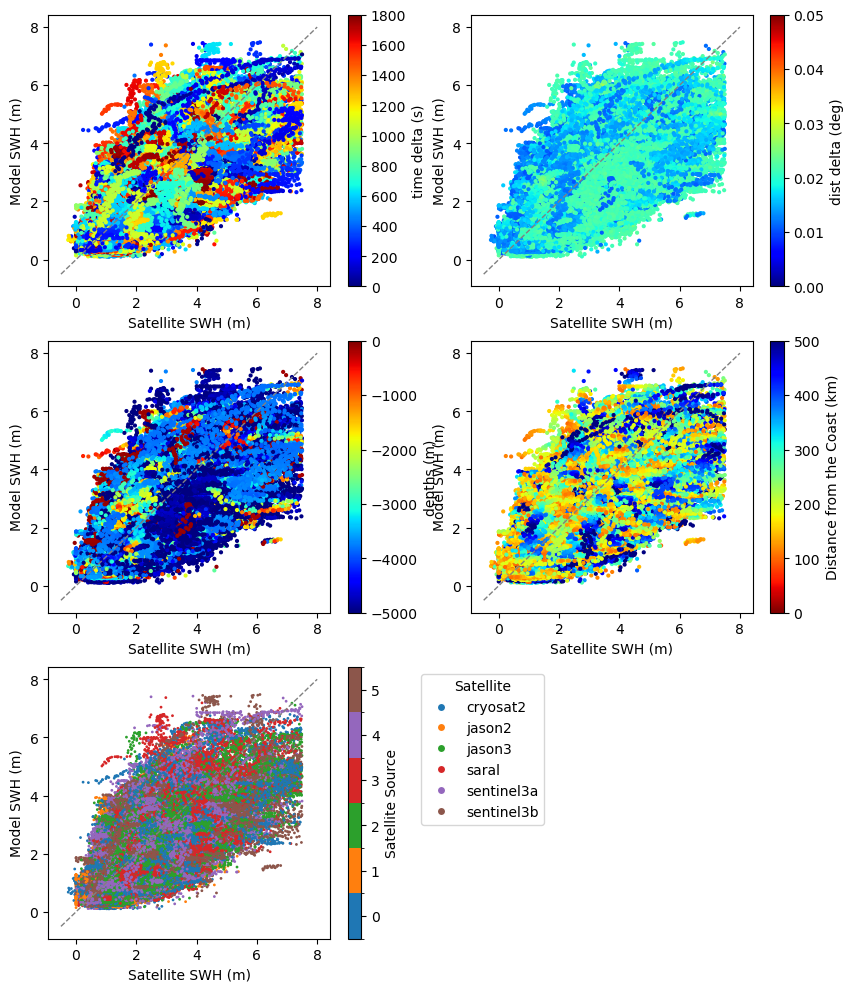

In [ ]:
source_cats, source_codes = np.unique(collocated_data.source_sat.values, return_inverse=True)
cmap_cat = plt.get_cmap("tab10")

norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, len(source_cats)+0.5), ncolors=len(source_cats))
plt.figure(figsize=(10,12))  # Increase figure size to fit 5 subplots

for i, params in enumerate(plot_params, 1):
    plt.subplot(3, 2, i)
    sc = plt.scatter(x, y, c=params["z"], cmap=params["cmap"], 
                     vmin=params["vmin"], vmax=params["vmax"],
                     s=4, alpha=1)
    plt.colorbar(sc, label=params["label"])
    plt.plot([-.5, math.ceil(xy_max)], [-.5, math.ceil(xy_max)], color="gray", linestyle="--", linewidth=1)
    plt.xlabel("Satellite SWH (m)")
    plt.ylabel("Model SWH (m)")

# Add the new subplot for source_sat (categorical)
plt.subplot(3, 2, 5)
sc = plt.scatter(x, y, c=source_codes, cmap=cmap_cat, norm=norm, s=1, alpha=1)
plt.colorbar(sc, ticks=np.arange(len(source_cats)), label="Satellite Source")
plt.clim(-0.5, len(source_cats)-0.5)
# plt.xticks(rotation=45)
plt.plot([-.5, math.ceil(xy_max)], [-.5, math.ceil(xy_max)], color="gray", linestyle="--", linewidth=1)
plt.xlabel("Satellite SWH (m)")
plt.ylabel("Model SWH (m)")

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w',
                          label=label, markerfacecolor=cmap_cat(i), markersize=6)
                   for i, label in enumerate(source_cats)]
plt.legend(handles=legend_elements, title="Satellite", bbox_to_anchor=(1.3, 1), loc='upper left')
# plt.tight_layout()